In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [2]:
import pprint
from pathlib import Path

import natsort
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm
import bnpm.server
import bnpm.plotting_helpers
import bnpm.file_helpers
import bnpm.path_helpers
import bnpm.indexing
import bnpm.timeSeries
import bnpm.decomposition

import bnpm.parallel_helpers

In [4]:
import itertools
import datetime

import scipy.io
import pandas as pd
import numpy as np
import matplotlib as mpl

In [5]:
mouse = 'mouse_g1'

In [6]:
# ## mouse_B

# dates_toUse = [
#     '20221021',
#     '20221022',
#     '20221023',
#     '20221024',
#     '20221025',
#     '20221026',
#     '20221028',
#     '20221029',
#     '20221030',
#     '20221031',
#     '20221101',
#     '20221102',
#     '20221103',
#     '20221104',
#     '20221105',
#     '20221106',
# ]

In [7]:
## mouse_g1

dates_toUse = [
    '20221011',
    '20221013',
    '20221014',
    '20221015',
    '20221016',
]

In [8]:
# ## mouse_2_6

# dates_toUse = [
#     '20210409',
#     '20210410',
#     '20210411',
#     '20210412',
#     '20210413',
#     '20210414',
#     '20210415',
#     '20210416',
#     '20210417',
# ]

In [9]:
Fs = 30

In [10]:
dir_save_data = f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}'

# Get files from server

input credentials for server

In [10]:
import getpass

remote_host_transfer = "transfer.rc.hms.harvard.edu"
remote_host_compute = "o2.hms.harvard.edu"
username = input('Username: ')
pw = bnpm.server.pw_encode(getpass.getpass(prompt='Password: '))

Username: rh183
Password: ········


prepare sftp client

In [11]:
ssh_t = bnpm.server.ssh_interface()

ssh_t.o2_connect(
    hostname=remote_host_transfer,
    username=username,
    password=bnpm.server.pw_decode(pw),
    skip_passcode=False,
    key_filename=None,
    look_for_keys=False,
    passcode_method=1,
    verbose=1,
)

sftp_t = bnpm.server.sftp_interface(ssh_t.client)

Duo two-factor login for rh183

Enter a passcode or select one of the following options:

 1. Duo Push to XXX-XXX-4151
 2. Phone call to XXX-XXX-4151
 3. SMS passcodes to XXX-XXX-4151

Passcode or option (1-3): 
1



Pushed a login request to your device...

Success. Logging you in...

Welcome to O2 (Orchestra 2)!

   ___    ____
  / _ \  |___ \
 | | | |   __) |
 | |_| |  / __/
  \___/  |_____|


You've landed on transfer03 which is a
4 core system with 7.62 GiB memory
running kernel 3.10.0 born on 2020-07-31

==== O2 ===================================================================

  News (Sep 8 2022)
  

  +-------------------------------------------------------------------------------+
  | ###################### Try out the new O2 Portal! ########################### |
  |                                                                               |
  | * Access O2 via the web! Just point your web browser to                       |
  |   o2portal.rc.hms.harvard.edu and login wit

### find logger files
Search for logger files and associated expParams files

In [47]:
paths_logger_raw = sftp_t.search_recursive(
#     path=f'/n/files/Neurobio/MICROSCOPE/Gyu/BMI_data/{mouse}',
    path=f'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/{mouse}/scanimage',
    search_pattern_re='logger.mat',
    max_depth=5,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger.mat


In [48]:
# paths_logger = {Path(p).parent.parent.name: p for p in natsort.natsorted(paths_logger_raw)}  ## mouse_g1
# paths_logger = {Path(p).parent.parent.name: p for p in natsort.natsorted(paths_logger_raw) if Path(p).parent.name == 'analysis_data'}  ## mouse_B
paths_logger = {Path(p).parent.name: p for p in natsort.natsorted(paths_logger_raw)}  ## mouse 2_6
display(paths_logger)

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger.mat',
 '20210417': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/logger.mat'}

In [50]:
paths_loggerAligned_raw = sftp_t.search_recursive(
#     path=f'/n/data1/hms/neurobio/sabatini/rich/analysis/logger_alignment/{mouse}',
    path=f'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/{mouse}/scanimage',
    search_pattern_re='logger_aligned.mat',
    max_depth=5,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_aligned.mat


In [51]:
paths_loggerAligned = {Path(p).parent.name: p for p in natsort.natsorted(paths_loggerAligned_raw)}
# paths_loggerAligned = {Path(p).parent.parent.name: p for p in natsort.natsorted(paths_loggerAligned_raw)}
display(paths_loggerAligned)

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_aligned.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_aligned.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_aligned.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_aligned.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_aligned.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_aligned.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_aligned.mat',
 '20210417': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mo

In [52]:
paths_logger_valsROIs_aligned_raw = sftp_t.search_recursive(
#     path=f'/n/data1/hms/neurobio/sabatini/rich/analysis/logger_alignment/{mouse}',
    path=f'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/{mouse}/scanimage',
    search_pattern_re='logger_valsROIs_aligned.mat',
    max_depth=5,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_valsROIs_aligned.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_valsROIs_aligned.mat


In [53]:
paths_logger_valsROIs_aligned = {Path(p).parent.name: p for p in natsort.natsorted(paths_logger_valsROIs_aligned_raw)}
# paths_logger_valsROIs_aligned = {Path(p).parent.parent.name: p for p in natsort.natsorted(paths_logger_valsROIs_aligned_raw)}
display(paths_logger_valsROIs_aligned)

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_valsROIs_aligned.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_valsROIs_aligned.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_valsROIs_aligned.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_valsROIs_aligned.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_valsROIs_aligned.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_valsROIs_aligned.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_valsROIs_aligned.mat',
 '20210417': '/n/dat

In [54]:
paths_expParams_raw = sftp_t.search_recursive(
#     path=f'/n/files/Neurobio/MICROSCOPE/Gyu/BMI_data/{mouse}',
    path=f'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/{mouse}/scanimage',
    search_pattern_re='expParams.mat',
    max_depth=5,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/expParams.mat
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/expParams.mat


In [56]:
# paths_expParams = {Path(p).parent.parent.name: p for p in natsort.natsorted(paths_expParams_raw)}
paths_expParams = {Path(p).parent.name: p for p in natsort.natsorted(paths_expParams_raw)}
display(paths_expParams)

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/expParams.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/expParams.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/expParams.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/expParams.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/expParams.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/expParams.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/expParams.mat',
 '20210417': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/expParam

In [57]:
paths_stat_raw = sftp_t.search_recursive(
#     path=f'/n/data1/hms/neurobio/sabatini/rich/analysis/suite2p_output/{mouse}',
    path=f'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/{mouse}/scanimage',
    search_pattern_re='stat.npy',
    max_depth=5,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/stat.npy
/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/stat.npy
/n/data1

In [58]:
paths_stat = natsort.natsorted([p for p in paths_stat_raw if '/exp/' in p])

In [60]:
# paths_stat = {Path(p).parent.parent.parent.parent.parent.parent.name: p for p in natsort.natsorted(paths_stat)}
paths_stat = {Path(p).parent.parent.parent.parent.name: p for p in natsort.natsorted(paths_stat_raw)}
display(paths_stat)

{'20210409': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/stat.npy',
 '20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/stat.npy',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/stat.npy',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/stat.npy',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/stat.npy',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/stat.npy',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/stat.npy',
 '20210416': '/

In [61]:
paths_ops = {date: str(Path(p).parent / 'ops.npy') for date,p in paths_stat.items()}

In [62]:
paths_ops

{'20210409': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/ops.npy',
 '20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/ops.npy',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/ops.npy',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/ops.npy',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/ops.npy',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/ops.npy',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/ops.npy',
 '20210416': '/n/data1

In [63]:
paths_F = {date: str(Path(p).parent / 'F.npy') for date,p in paths_stat.items()}

In [64]:
paths_F

{'20210409': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/F.npy',
 '20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/F.npy',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/F.npy',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/F.npy',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/F.npy',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/F.npy',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/F.npy',
 '20210416': '/n/data1/hms/neurobio/

In [65]:
paths_Fneu = {date: str(Path(p).parent / 'Fneu.npy') for date,p in paths_stat.items()}

In [66]:
paths_Fneu

{'20210409': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/Fneu.npy',
 '20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/Fneu.npy',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/Fneu.npy',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/Fneu.npy',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/Fneu.npy',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/Fneu.npy',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/Fneu.npy',
 '20210416': '/

In [67]:
paths_spks = {date: str(Path(p).parent / 'spks.npy') for date,p in paths_stat.items()}

In [68]:
paths_spks

{'20210409': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/spks.npy',
 '20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/exp/suite2p/plane0/spks.npy',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/exp/suite2p/plane0/spks.npy',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/exp/suite2p/plane0/spks.npy',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/exp/suite2p/plane0/spks.npy',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/exp/suite2p/plane0/spks.npy',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/exp/suite2p/plane0/spks.npy',
 '20210416': '/

In [69]:
assert all([sftp_t.exists(p) for date,p in paths_ops.items()])

In [70]:
paths_local_tmp = [str(Path(dir_save_data) / 'statFiles' / d) for d,_ in paths_stat.items()]
[Path(p).mkdir(parents=True, exist_ok=True) for p in paths_local_tmp];

In [71]:
[sftp_t.sftp.get(
    remotepath=p_r,
    localpath=str(Path(p_l) / 'stat.npy'),
) for (date, p_r), p_l in tqdm(zip(paths_stat.items(), paths_local_tmp))];

9it [00:05,  1.53it/s]


In [72]:
[sftp_t.sftp.get(
    remotepath=p_r,
    localpath=str(Path(p_l) / 'ops.npy'),
) for (date, p_r), p_l in tqdm(zip(paths_ops.items(), paths_local_tmp))];

9it [01:17,  8.65s/it]


In [73]:
[sftp_t.sftp.get(
    remotepath=p_r,
    localpath=str(Path(p_l) / 'F.npy'),
) for (date, p_r), p_l in tqdm(zip(paths_F.items(), paths_local_tmp))];

9it [07:47, 51.95s/it]


In [74]:
[sftp_t.sftp.get(
    remotepath=p_r,
    localpath=str(Path(p_l) / 'Fneu.npy'),
) for (date, p_r), p_l in tqdm(zip(paths_Fneu.items(), paths_local_tmp))];

9it [07:41, 51.31s/it]


In [75]:
[sftp_t.sftp.get(
    remotepath=p_r,
    localpath=str(Path(p_l) / 'spks.npy'),
) for (date, p_r), p_l in tqdm(zip(paths_spks.items(), paths_local_tmp))];

9it [07:27, 49.69s/it]


### subselect dates to use

In [76]:
paths_loggerAligned = {key: val for key, val in paths_loggerAligned.items() if key in dates_toUse}
paths_logger_valsROIs_aligned = {key: val for key, val in paths_logger_valsROIs_aligned.items() if key in dates_toUse}
paths_logger = {key: val for key, val in paths_logger.items() if key in dates_toUse}
paths_expParams = {key: val for key, val in paths_expParams.items() if key in dates_toUse}

### get logger and expParams files
Pull them into a temp directory structure

make a directory structure based on the naming of the directories in remote.\
Might need to add or remove `.parent` suffices to `Path(p).resolve().parent`

In [77]:
folderNames_session = [str(p) for p in paths_logger.keys()]
dirs_save_session = [str(Path(dir_save_data).resolve() / 'loggers'/ n) for n in folderNames_session]

check to make sure these are the dated session folder names

In [78]:
display(folderNames_session)

['20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417']

In [79]:
paths_loggerAligned

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_aligned.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_aligned.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_aligned.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_aligned.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_aligned.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_aligned.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_aligned.mat',
 '20210417': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mo

In [80]:
paths_logger_valsROIs_aligned

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/logger_valsROIs_aligned.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/logger_valsROIs_aligned.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/logger_valsROIs_aligned.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/logger_valsROIs_aligned.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/logger_valsROIs_aligned.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/logger_valsROIs_aligned.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/logger_valsROIs_aligned.mat',
 '20210417': '/n/dat

In [81]:
paths_expParams

{'20210410': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210410/expParams.mat',
 '20210411': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210411/expParams.mat',
 '20210412': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210412/expParams.mat',
 '20210413': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210413/expParams.mat',
 '20210414': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210414/expParams.mat',
 '20210415': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210415/expParams.mat',
 '20210416': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210416/expParams.mat',
 '20210417': '/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210417/expParam

In [82]:
## Make directories
[Path(d).mkdir(parents=True, exist_ok=True) for d in dirs_save_session];

## Enumerate paths for each session
paths_transfer = {folderName: {
    'path_loggerAligned_remote': paths_loggerAligned[folderName], 
    'path_loggerAligned_local': str(Path(dirs_save_session[i_folder]) / 'logger_aligned.mat'),
    'path_loggerValsAligned_remote': paths_logger_valsROIs_aligned[folderName], 
    'path_loggerValsAligned_local': str(Path(dirs_save_session[i_folder]) / 'logger_valsROIs_aligned.mat'),
    'path_logger_remote': paths_logger[folderName], 
    'path_logger_local': str(Path(dirs_save_session[i_folder]) / 'logger.mat'),
    'path_expParams_remote': paths_expParams[folderName],
    'path_expParams_local': str(Path(dirs_save_session[i_folder]) / 'expParams.mat'),
#     'path_loggerAlignmentVectors_remote': paths_loggerAlignmentVectors[i_folder],
#     'path_loggerAlignmentVectors_local': str(Path(dirs_save_session[i_folder]) / 'logger_alignment_vectors.mat'),
#     'path_loggerAligned_remote': paths_loggerAligned[i_folder],
#     'path_loggerAligned_local': str(Path(dirs_save_session[i_folder]) / 'logger_aligned.mat'),
} for i_folder, folderName in enumerate(folderNames_session)}

In [83]:
for folderName, paths in tqdm(paths_transfer.items()):
    sftp_t.sftp.get(remotepath=paths['path_loggerAligned_remote'], localpath=paths['path_loggerAligned_local'])
    sftp_t.sftp.get(remotepath=paths['path_loggerValsAligned_remote'], localpath=paths['path_loggerValsAligned_local'])
    sftp_t.sftp.get(remotepath=paths['path_logger_remote'], localpath=paths['path_logger_local'])
    sftp_t.sftp.get(remotepath=paths['path_expParams_remote'], localpath=paths['path_expParams_local'])
#     sftp_t.sftp.get(remotepath=paths['path_loggerAlignmentVectors_remote'], localpath=paths['path_loggerAlignmentVectors_local'])
#     sftp_t.sftp.get(remotepath=paths['path_loggerAligned_remote'], localpath=paths['path_loggerAligned_local'])

100%|█████████████████████████████████████████████| 8/8 [01:25<00:00, 10.73s/it]


download ROICaT output

In [85]:
path_save = str(Path(dir_save_data).resolve() / 'roicat.pkl')

sftp_t.sftp.get(
    remotepath=f'/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_tracking/{mouse}/{mouse}.ROICaT.results.pkl',
    localpath=path_save,
)

download `iscell_NN_tqm.npy`

In [54]:
path_save = str(Path(dir_save_data).resolve() / 'iscell_NN_tqm.npy')

sftp_t.sftp.get(
    remotepath=f'/n/files/Neurobio/MICROSCOPE/Gyu/BMI_data/{mouse}/20221010/analysis_data/day0_analysis/iscell_NN_tqm.npy',
    localpath=path_save,
)

download spike_prob

In [90]:
paths_spikeProb = sftp_t.search_recursive(
    path=f'/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/{mouse}',
    search_pattern_re='spike_prob_\d',
    max_depth=12,
    find_files=True,
    find_folders=False,
    verbose=True,
)

/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_1.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_2.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_0.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_8.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_4.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_5.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_6.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_7.npy
/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_3.npy


In [91]:
paths_spikeProb = natsort.natsorted(paths_spikeProb)
paths_spikeProb

['/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_0.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_1.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_2.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_3.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_4.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_5.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_6.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neural_data/spike_prob_7.npy',
 '/n/data1/hms/neurobio/sabatini/rich/analysis/spike_inference/mouse_2_6/mouse_2_6/neura

In [96]:
paths_save = []
dates = []
for i_file, path in enumerate(paths_spikeProb):
    date = Path(path).resolve().parent.parent.name
#     date = dates_toUse[i_file]
    print(f'date: {date}')
    dates.append(date)
    path_save = str(Path(dir_save_data).resolve() / 'spike_prob' / f'{date}_spikeProb.npy')
    paths_save.append(path_save)
    Path(path_save).parent.mkdir(parents=True, exist_ok=True)
    sftp_t.sftp.get(
        remotepath=path,
        localpath=path_save,
    )

date: 20210409
date: 20210410
date: 20210411
date: 20210412
date: 20210413
date: 20210414
date: 20210415
date: 20210416
date: 20210417


# Import Data from local

### logger and expParams

make lists of logger dicts and expParams dicts

In [97]:
# logger_objs    = {folderName: scipy.io.loadmat(file_name=p, simplify_cells=True)['logger']    for folderName,p in {folderName: pt['path_logger_local']    for folderName,pt in paths_transfer.items()}.items()}
# loggerAligned_objs    = {folderName: scipy.io.loadmat(file_name=p, simplify_cells=True)['logger_aligned']    for folderName,p in {folderName: pt['path_loggerAligned_local']    for folderName,pt in paths_transfer.items()}.items()}
# expParams_objs = {folderName: scipy.io.loadmat(file_name=p, simplify_cells=True)['expParams'] for folderName,p in {folderName: pt['path_expParams_local'] for folderName,pt in paths_transfer.items()}.items()}
# # loggerAlignmentVectors_objs = [scipy.io.loadmat(file_name=p, simplify_cells=True)['logger_alignment_vectors'] for p in [pt['path_loggerAlignmentVectors_local'] for folderName,pt in paths_transfer.items()]]
# # loggerAligned_objs = [scipy.io.loadmat(file_name=p, simplify_cells=True)['logger_aligned'] for p in [pt['path_loggerAligned_local'] for folderName,pt in paths_transfer.items()]]

In [11]:
paths_local_logger = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/loggers/',
    reMatch='logger.mat',
    depth=2
)
paths_local_logger = [p for p in paths_local_logger if Path(p).parent.name in dates_toUse]
display(paths_local_logger)


load_logger = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['logger']}

logger_objs = {}
[logger_objs.update(load_logger(path)) for path in paths_local_logger];

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221011/logger.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221013/logger.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221014/logger.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221015/logger.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221016/logger.mat']

In [12]:
paths_local_loggerAligned = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/loggers/',
    reMatch='logger_aligned.mat',
    depth=2
)
paths_local_loggerAligned = [p for p in paths_local_loggerAligned if Path(p).parent.name in dates_toUse]
display(paths_local_loggerAligned)

load_loggerAligned = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['logger_aligned']}

loggerAligned_objs = {}
[loggerAligned_objs.update(load_loggerAligned(path)) for path in paths_local_loggerAligned];

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221011/logger_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221013/logger_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221014/logger_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221015/logger_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221016/logger_aligned.mat']

In [13]:
paths_local_loggerValsAligned = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/loggers/',
    reMatch='logger_valsROIs_aligned.mat',
    depth=2
)
paths_local_loggerValsAligned = [p for p in paths_local_loggerValsAligned if Path(p).parent.name in dates_toUse]
display(paths_local_loggerValsAligned)

load_loggerValsAligned = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['logger_valsROIs_aligned']}

loggerValsAligned_objs = {}
[loggerValsAligned_objs.update(load_loggerValsAligned(path)) for path in tqdm(paths_local_loggerValsAligned)];
# bnpm.parallel_helpers.map_parallel(lambda p: loggerValsAligned_objs.update(load_loggerValsAligned(p)), paths_local_loggerValsAligned, method='serial');

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221011/logger_valsROIs_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221013/logger_valsROIs_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221014/logger_valsROIs_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221015/logger_valsROIs_aligned.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221016/logger_valsROIs_aligned.mat']

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


In [14]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/loggers/',
    reMatch='expParams.mat',
    depth=2
)
paths_local_expParams = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_expParams)

load_expParams = lambda path: {Path(path).parent.name: scipy.io.loadmat(file_name=path, simplify_cells=True)['expParams']}

expParams_objs = {}
[expParams_objs.update(load_expParams(path)) for path in paths_local_expParams];

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221011/expParams.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221013/expParams.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221014/expParams.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221015/expParams.mat',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/loggers/20221016/expParams.mat']

## Import F and Fneu

In [15]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/statFiles/',
    reMatch='F.npy',
    depth=2
)
paths_local_F = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_F)

F_objs = {}
def loader(path):
    F_objs.update({Path(path).parent.name: np.load(path)})
[F_objs.update({Path(path).parent.name: np.load(path)}) for path in tqdm(paths_local_F)];
# bnpm.parallel_helpers.map_parallel(loader, paths_local_F, method='mpire');

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221011/F.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221013/F.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221014/F.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221015/F.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221016/F.npy']

100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


In [16]:
paths_local_expParams = bnpm.path_helpers.find_paths(
    dir_outer=f'/media/rich/bigSSD/downloads_tmp/tmp_data/{mouse}/statFiles/',
    reMatch='Fneu.npy',
    depth=2
)
paths_local_Fneu = [p for p in paths_local_expParams if Path(p).parent.name in dates_toUse]
display(paths_local_Fneu)


Fneu_objs = {}
def loader(path):
    Fneu_objs.update({Path(path).parent.name: np.load(path)})
[Fneu_objs.update({Path(path).parent.name: np.load(path)}) for path in tqdm(paths_local_Fneu)];
# bnpm.parallel_helpers.map_parallel(loader, paths_local_Fneu, method='multiprocessing');

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221011/Fneu.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221013/Fneu.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221014/Fneu.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221015/Fneu.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/statFiles/20221016/Fneu.npy']

100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.85s/it]


make dataframes for each logger using the loggerNames field from expParams

### WARNING:

in the line:
```
...
            data=logger[key_outer][:, :len(expParams['loggerNames'][key_outer])], 
...            
```
the indexing: `[:, :len(expParams['loggerNames'][key_outer])]` is used because the length of the logger is sometimes too long. This should be fine for most experiments, but just a heads up that if the `expParams['loggerNames']` and actual logger data doesn't match up then this is screwed.

In [17]:
logger_dfs = {
    date: {
        key_outer: pd.DataFrame(
            data=logger_objs[date][key_outer][:, :len(expParams_objs[date]['loggerNames'][key_outer])], 
            columns=expParams_objs[date]['loggerNames'][key_outer],
        ) for key_outer in expParams_objs[date]['loggerNames'].keys()
    } for date in expParams_objs.keys()
}

Drop th 'trials' field into the loggerAligned objects from the logger objects

In [18]:
[loggerAligned_objs[date].update({'trials': logger_objs[date]['trials']}) for date in loggerAligned_objs.keys()];

In [19]:
loggerAligned_dfs = {
    date: {
        key_outer: pd.DataFrame(
            data=loggerAligned_objs[date][key_outer][:, :len(expParams_objs[date]['loggerNames'][key_outer])], 
            columns=expParams_objs[date]['loggerNames'][key_outer],
        ) for key_outer in expParams_objs[date]['loggerNames'].keys()
    } for date in expParams_objs.keys()
}

Determine the duration of each trial.\
Note that the `'trial_now_'` fields appear to be busted. So it is safter to use the `'counter_frameNum_'` fields and just make sure to correct them using the alignment vectors.

To align raw logger indices to scanimage/suite2p indices, use the `logger_alignment_vectors` file and the `inds_align_movie_to_logger` field within it. You can use the `bnpm.indexing.index_with_nans` function to reindex a raw logger time series as such: 
```
ts_SI = bnpm.indexing.index_with_nans(
    values=ts_logger,
    indices=logger_alignment_vectors['inds_align_movie_to_logger']-1
)
```

To convert index values from logger indices to scanimage/suite2p indices, use the `inds_align_logger2movie` field. You can also use it with the `index_with_nans` function as such:
```
frame_start_SI = bnpm.indexing.index_with_nans(
        values=logger_alignment_vectors['inds_align_logger2movie'],
        indices=frame_start_logger,
    )

Also note that loggers BEFORE 2022.12.13 have a bug that appears in failure trials that occur after failure trials. Their duration will appear negative. This is because the update trial info happens after iterating the trial number instead of before:
```
trialNum = trialNum + 1
updateLoggerTrials_END(0)
```

## make `loggerVals_rollZ`

In [20]:
def zscore_rolling(X, wlen=100, axis=0, X_denom=None):
    X_df = pd.DataFrame(X)
    kwargs = {'min_periods': 1, 'center': False, 'win_type': None, 'closed': None}
    if X_denom is not None:
        X_std = pd.DataFrame(X_denom).rolling(wlen, axis=axis, **kwargs).std(ddof=0).to_numpy()
    else:
        X_std = X_df.rolling(wlen, axis=axis, **kwargs).std(ddof=0).to_numpy()
    X_std[X_std < 0.01] = np.inf
    return X_df.sub(X_df.rolling(wlen, axis=axis, **kwargs).mean()).div(X_std).to_numpy()


In [21]:
wlen = Fs * 60 * 15

# loggerVals_rollZ = {date: zscore_rolling(l, wlen=wlen).T for date,l in tqdm(loggerValsAligned_objs.items())}
loggerVals_rollZ = {}
def func_tmp(date_l):
    date, l = date_l
    return loggerVals_rollZ.update({date: zscore_rolling(l, wlen=wlen).T})
bnpm.parallel_helpers.map_parallel(func_tmp, loggerValsAligned_objs.items(), method='multithreading');

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


In [22]:
d_test = expParams_objs['20221030']['baselineStuff']['ROIs']['cellWeightings']

%matplotlib notebook
plt.figure()
plt.plot(loggerVals_rollZ['20221030'].T @ d_test)
# plt.plot(test)
plt.plot(loggerAligned_dfs['20221030']['decoder']['cursor_brain_raw'])


KeyError: '20221030'

### Extract trial statistics

In [23]:
n_sessions = len(logger_dfs)

trials_duration_frame = []
trials_duration_nowTime = []
trials_success = []
trials_type_111 = []

for logger_df in logger_dfs.values():
    ## pull out frames of start and end. -1 to account for matlab 1-indexing
    frame_start__idx_logger = logger_df['trials']['counter_frameNum_trialStart'].to_numpy() - 1
    frame_end__idx_logger = logger_df['trials']['counter_frameNum_trialEnd'].to_numpy() - 1   
#     frame_start__idx_SI = bnpm.indexing.index_with_nans(
#         values=align['inds_align_logger2movie'],
#         indices=frame_start__idx_logger,
#     )
#     frame_end__idx_SI = bnpm.indexing.index_with_nans(
#         values=align['inds_align_logger2movie'],
#         indices=frame_end__idx_logger,
#     )
#     trials_duration_frame.append((frame_end__idx_SI - frame_start__idx_SI))
    
    ## pull out durations using time
    time_start__idx_logger = logger_df['trials']['time_now_trialStart'].to_numpy()
    time_end__idx_logger = logger_df['trials']['time_now_trialEnd'].to_numpy()
    trials_duration_nowTime.append((time_end__idx_logger - time_start__idx_logger))

    ## pull out whether the outcome was a success
    trials_success.append(logger_df['trials']['success_outcome'] == 1)
    
    ## pull out whether the trial type was a standard trial with feedback, reward, and cursor all one (1 1 1)
    trials_type_111.append((logger_df['trials']['trialType_cursorOn'] == 1) * (logger_df['trials']['trialType_feedbackLinked'] == 1) * (logger_df['trials']['trialType_rewardOn'] == 1))
    

Plot number of successful trials over sessions

In [24]:
trials_numSuccess__111 = [np.nansum(trials_success[ii][trials_type_111[ii]]) for ii in range(n_sessions)]

<IPython.core.display.Javascript object>


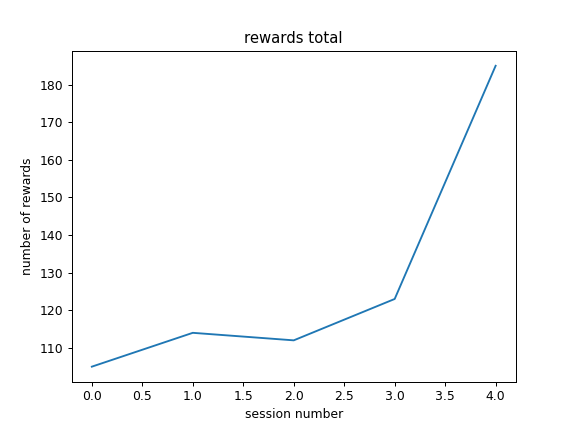

Text(0.5, 1.0, 'rewards total')

In [187]:
plt.figure()
plt.plot(trials_numSuccess__111)
plt.xlabel('session number')
plt.ylabel('number of rewards');
plt.title('rewards total')

Plot duration of successful trials over sessions as a histogram

In [26]:
trials_duration_time__success_111 = [trials_duration_nowTime[sn][trials_success[sn] * trials_type_111[sn]] * 24*60*60 for sn in range(len(trials_duration_nowTime))]

edges = np.linspace(0,20, num=41, endpoint=True)
trials_durationHist_time__success_111 = np.array([np.histogram(t, bins=edges)[0] for t in trials_duration_time__success_111]).T

<IPython.core.display.Javascript object>


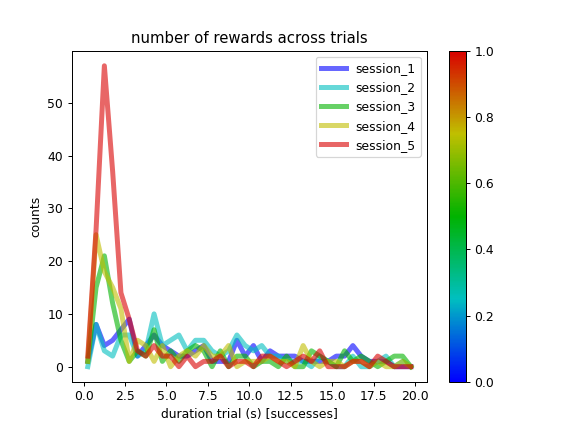

In [185]:
%matplotlib notebook

cmap = bnpm.plotting_helpers.simple_cmap(colors=[[0.0, 0.0, 1.0], [0.0, 0.75, 0.75], [0.0, 0.7, 0.0], [0.75, 0.75, 0], [0.85, 0.0, 0.0]])

plt.figure()
for ii,trace in enumerate(trials_durationHist_time__success_111.T):
    plt.plot(
        (edges[1:] +edges[:-1])/2, 
        trace, 
        color=cmap(ii/(n_sessions-1)), 
        linewidth=4,
        alpha=0.6,
    )
    
# [plt.stairs(t[0], t[1], color=colors[ii], linewidth=4) for ii,t in enumerate(trials_durationHist_time__success_111)];
plt.xlabel('duration trial (s) [successes]')
plt.ylabel('counts')
plt.title('number of rewards across trials')
plt.legend([f'session_{ii}' for ii in np.arange(n_sessions)+1])
ax = plt.gca()
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax);

<IPython.core.display.Javascript object>


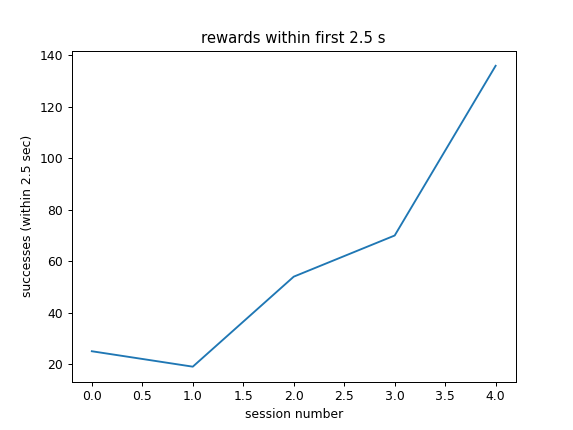

Text(0.5, 1.0, 'rewards within first 2.5 s')

In [186]:
plt.figure()
plt.plot(trials_durationHist_time__success_111[:5,:].sum(0))
plt.xlabel('session number')
plt.ylabel('successes (within 2.5 sec)')
plt.title('rewards within first 2.5 s')

### NOTE:

In earlier experiments use `CE_ITI_successful` and in later experiments use `CE_ITI_withZ`

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(n_sessions, 1, sharex=True, figsize=(50, n_sessions*1.5))

for i_sesh,date in enumerate(expParams_objs.keys()):

    names_states = expParams_objs[date]['loggerNames']['timeSeries']

    names_toPlot = [
        'CE_trial',
        'CE_rewardToneHold',
        'CE_rewardDelivery',
        'CE_ITI_withZ',
        'CE_waitForBaseline',
        'CE_timeout'
    ]
    idx_toPlot = np.isin(names_states, names_toPlot)

    n_samples = logger_objs[date]['timeSeries'].shape[0]

    colors = {
        'CE_trial': (0.7, 0.7, 0.7),
        'CE_rewardToneHold': (0.0, 0.7, 0.0),
        'CE_rewardDelivery': (0.0, 0.7, 0.2),
        'CE_ITI_withZ': (0.0, 0.7, 0.6),
        'CE_waitForBaseline': (0.2, 0.2, 0.1),
        'CE_timeout': (1.0, 0.2, 0.0),
    }

    assert all([n_c == n_tp for n_c, n_tp in zip(list(colors.keys()), names_toPlot)])

    for name in names_toPlot:
        axs[i_sesh].fill_between(
            x=np.arange(n_samples),
            y1=logger_objs[date]['timeSeries'][:, np.isin(names_states, name)][:,0] * 10 - 5,
            y2=-5,
            alpha=0.6,
            color=colors[name],
            linewidth=0
        )
    axs[i_sesh].plot(logger_objs[date]['decoder'][:, expParams_objs[date]['loggerNames']['decoder'] == 'cursor_brain'], 'k')
    axs[i_sesh].set_ylim(-2,3)

## Analyze alignment

In [29]:
path_roicat = str(Path(dir_save_data).resolve() / 'roicat.pkl')
roicat_out = bnpm.file_helpers.pickle_load(path_roicat)

In [30]:
len(roicat_out['UCIDs_bySession'])

7

In [31]:
path_iscell = str(Path(dir_save_data).resolve() / 'iscell_NN_tqm.npy')
iscell = np.load(path_iscell, allow_pickle=True)

## import spike_prob

In [32]:
paths_spikeProb = bnpm.path_helpers.find_paths(
    dir_outer=dir_save_data,
    reMatch='spike_prob',
    depth=3,
)
paths_spikeProb

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221010_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221011_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221012_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221013_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221014_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221015_spikeProb.npy',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g1/spike_prob/20221016_spikeProb.npy']

In [33]:
# sp_raw = {Path(p).name[:8]: np.load(p).astype(np.float32) for p in tqdm(paths_spikeProb)}

sp_raw = {}
def func_tmp(path):
    sp_raw.update({Path(path).name[:8]: np.load(path).astype(np.float32)})
bnpm.parallel_helpers.map_parallel(func_tmp, paths_spikeProb, method='multithreading');

100%|█████████████████████████████████████████████| 7/7 [00:44<00:00,  6.40s/it]


In [74]:
# ucids_decoderVector = roicat_out['UCIDs_bySession'][0][iscell]

In [75]:
ucids_decoderVector = roicat_out['UCIDs_bySession'][0]

In [76]:
assert len(sp_raw) == len(roicat_out['UCIDs_bySession']), f'Warning: number of spike_prob arrays is different from the number of ucids arrays'

In [77]:
## find indices in each session that match with UCID in the ucids_decoderVector array
### the (val>=0) bit is to make sure the -1 values are excluded

dates_roicat = [Path(p).parent.name for p in roicat_out['input_data']['paths_stat']]

idx_matching_decoderVector_raw = {date: [np.where((sesh == val) * (val>=0))[0] for val in ucids_decoderVector] for date,sesh in tqdm(zip(dates_roicat, roicat_out['UCIDs_bySession']))};

7it [00:00, 71.91it/s]


In [78]:
## turn into list of arrays
idx_matching_decoderVector = {date: np.array([val[0] if len(val)==1 else -1 for val in arr], dtype=np.int64) for date, arr in idx_matching_decoderVector_raw.items()}

In [79]:
## check to make sure there aren't any duplicates
assert all([all([len(idx)<=1 for idx in idx_raw]) for idx_raw in idx_matching_decoderVector_raw])

In [80]:
rois_matched = [rois[idx] for rois,idx in zip(roicat_out['ROIs']['ROIs_aligned'], idx_matching_decoderVector.values())]

In [81]:
import bnpm.ca2p_preprocessing

In [82]:
import torch

In [44]:
dFoF = {date: bnpm.ca2p_preprocessing.make_dFoF(
    F=F,
    Fneu=Fneu,
    neuropil_fraction=0.7,
    percentile_baseline=20,
    channelOffset_correction=200,
    multicore_pref=True,
    verbose=True,
)[0] for (date,F),(date,Fneu) in zip(F_objs.items(), Fneu_objs.items())}

Calculated dFoF. Total elapsed time: 8.11 seconds
Calculated dFoF. Total elapsed time: 1.07 seconds
Calculated dFoF. Total elapsed time: 1.07 seconds
Calculated dFoF. Total elapsed time: 1.03 seconds
Calculated dFoF. Total elapsed time: 1.08 seconds


In [54]:
sp_matched = {}
for date,sp in sp_raw.items():
    idx = idx_matching_decoderVector[date]
    arr = sp[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    sp_matched.update({date: arr})

In [55]:
F_matched = {}
for date,F in F_objs.items():
    idx = idx_matching_decoderVector[date]
    arr = F[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    F_matched.update({date: arr})

In [56]:
Fneu_matched = {}
for date,Fneu in Fneu_objs.items():
    idx = idx_matching_decoderVector[date]
    arr = Fneu[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    Fneu_matched.update({date: arr})

In [57]:
dFoF_matched = {}
for date,dfof in dFoF.items():
    idx = idx_matching_decoderVector[date]
    arr = dfof[idx]
    arr[idx==-1] = arr[idx==-1] * np.nan
    dFoF_matched.update({date: arr})

In [58]:
def get_frames_111_success(logger):
    frames_trialEnds = np.where(np.diff(logger['timeSeries']['CE_trial']) < 0)[0] + 1
    type_111_success = (logger['trials']['trialType_cursorOn'] * logger['trials']['trialType_feedbackLinked'] * logger['trials']['trialType_rewardOn'] * logger['trials']['success_outcome']).to_numpy()
    frames_111_success = frames_trialEnds[type_111_success[:len(frames_trialEnds)].astype(bool)]
    
    out = {
        'trialNum': logger['trials']['trialNum_trialStart'],
        'frames': frames_111_success,
        'duration': logger['trials']['counter_frameNum_trialEnd'] - logger['trials']['counter_frameNum_trialStart'],
    }
    
    return out

trials_111_success = {date: get_frames_111_success(logger) for date, logger in loggerAligned_dfs.items()}

In [59]:
def cosine_similarity(v1, v2):
    
    v1 = v1[:,None] if v1.ndim==1 else v1
    v2 = v2[:,None] if v2.ndim==1 else v2
    
    idx_notNaN = np.logical_not(np.isnan(v1.mean(1))) * np.logical_not(np.isnan(v2.mean(1)))

    v1 = v1[idx_notNaN]
    v2 = v2[idx_notNaN]

    return (v1.T @ v2) / (np.linalg.norm(v1, axis=0) * np.linalg.norm(v2, axis=0))[:,None]

In [60]:
def projection_magnitude(v1, v2):
    '''
    magnitude of v1 projected onto v2
    '''
    v1 = v1[:,None] if v1.ndim==1 else v1
    v2 = v2[:,None] if v2.ndim==1 else v2
    
    idx_notNaN = np.logical_not(np.isnan(v1.mean(1))) * np.logical_not(np.isnan(v2.mean(1)))

    v1 = v1[idx_notNaN]
    v2 = v2[idx_notNaN]

    return (v1.T @ v2) / np.linalg.norm(v2, axis=0)

Plots of projections

In [61]:
%matplotlib inline

In [ ]:
dir_save_results = r'/home/rich/Desktop/analysis_vectorSimilarity/'

# mouse = 'mouse_g1'

vecs_decoder = {
    'decoder_1': expParams_objs[dates_toUse[1]]['baselineStuff']['ROIs']['cellWeightings'],
#     'decoder_2': expParams_objs[dates_toUse[6]]['baselineStuff']['ROIs']['cellWeightings'],
#     'decoder_3': expParams_objs[dates_toUse[-1]]['baselineStuff']['ROIs']['cellWeightings'],
    'avgVector': np.ones(len(expParams_objs[dates_toUse[1]]['baselineStuff']['ROIs']['cellWeightings'])),
}

reductions = {
    'mean': np.nanmean,
    'std': np.nanstd,
}

projectionTypes = {
    'cosSim': cosine_similarity,
    'projMag': projection_magnitude,
}

params = [
    vecs_decoder,
    reductions,
    projectionTypes
]

win_bounds = [-30*8, 30*8]
cmap = bnpm.plotting_helpers.simple_cmap([[0,0,0.5], [0,0.5,0.8], [0,0.8,0], [0.8,0.3,0], [0.8,0,0]])
display(cmap)
colors = cmap(np.linspace(0,0.999, len(dates_toUse)))

for vec_decoder, reduction, projectionType in itertools.product(*[d.items() for d in params]):
    et_traces_reduced  = []
    for date in dates_toUse:
#         traces = sp_matched[date]
        traces = dFoF_matched[date]
#         traces = loggerVals_rollZ[date]

        et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
            arr=projectionType[1](traces, vec_decoder[1]).squeeze(),  
#             arr=projectionType[1](traces, expParams_objs[date]['baselineStuff']['ROIs']['cellWeightings']).squeeze(),
            trigger_signal=trials_111_success[date]['frames'],
            win_bounds=win_bounds,
            trigger_signal_is_idx=True,
        )
        et_traces_reduced.append(reduction[1](et_traces, axis=0))
    et_traces_reduced = np.stack(et_traces_reduced, axis=1)

    
    fig = plt.figure(figsize=(20,5))
    plt.title(f'{vec_decoder[0]}, {reduction[0]}, {projectionType[0]}')
    [plt.plot(xAxis/Fs, et_traces_reduced[:,ii] - et_traces_reduced[:50,ii].mean(0), color=c) for ii,c in enumerate(colors)]
    plt.plot([0,0], [0,0.25], 'k')
    
    name_results = f'etTraces_{vec_decoder[0]}_{reduction[0]}_{projectionType[0]}__{mouse}'
    print(f'name_results: {name_results}')

#     dict_save = {
#         'et_traces': et_traces_reduced.astype(np.float32).copy(),
#         'axes': {
#             'time (s)': xAxis / Fs,
#             'sessions': dates_toUse,
#         },
#         'date_made': str(datetime.datetime.date(datetime.datetime.now())),
#         'notes': '2D matrix of event triggered traces. Traces are spike probabilities (from CASCADE) projected onto the decoder axis, then the event triggered average is taken across events within a session. \
# The neurons were aligned across sessions using ROICaT, and subselected to only be those that were included in the online decoder. Neurons for which there was not ROICaT match were excluded from the calculation.',
#         'data_type': 'spike_probability, CASCADE',
#         'projection_type': projectionType[0],
#         'reduction': reduction[0],
#         'decoder_ID': vec_decoder[0],
#         'animal_ID': mouse,
#     }

#     path_save = str(Path(dir_save_results) / f'{name_results}.pkl')
#     bnpm.file_helpers.pickle_save(dict_save, path_save, mkdir=True, allow_overwrite=False)


#     fig_saver = bnpm.plotting_helpers.Figure_Saver(dir_save_results, overwrite=True)
#     fig_saver(fig, name_file=name_results)

Make dimensionality plot

In [58]:
win_bounds = [-30*8, 30*8]

dims = []
for date in tqdm(dates_toUse):
    et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
        arr=sp_matched[date],
#         arr=np.nan_to_num(loggerVals_rollZ[date]),
        trigger_signal=trials_111_success[date]['frames'],
        win_bounds=win_bounds,
        trigger_signal_is_idx=True
    )
#     et_traces = bnpm.timeSeries.convolve_along_axis(et_traces, bnpm.math_functions.gaussian(sig=10), axis=-1, multicore_pref=True)
    et_traces = bnpm.timeSeries.convolve_torch(et_traces.transpose(2,0,1), bnpm.math_functions.gaussian(sig=10), padding='same').numpy().transpose(1,2,0)
    
#     plt.figure()
#     plt.imshow(np.nan_to_num(et_traces[:,:,230].T), aspect='auto', vmin=0, vmax=0.2)

    dim = bnpm.decomposition.dimensionality_pca(np.nan_to_num(et_traces[:,:,230].T, nan=0.0), ev=bnpm.math_functions.bounded_logspace(0.1, 0.99, 10), device='cpu')
    dims.append(dim)

dims = np.stack(dims, axis=0)

/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/bnpm/timeSeries.py:551: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  convolved = torch.nn.functional.conv1d(X_rshp, kernel_rshp, **conv1d_kwargs)


In [60]:
bnpm.math_functions.bounded_logspace(0.1, 0.99, 10),

(array([0.1       , 0.12901082, 0.16643791, 0.21472292, 0.27701579,
        0.35738034, 0.46105931, 0.59481639, 0.7673775 , 0.99      ]),)

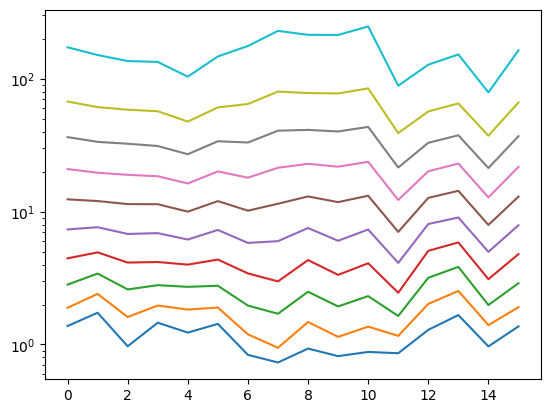

In [61]:
plt.figure()
plt.plot(dims)
plt.yscale('log');

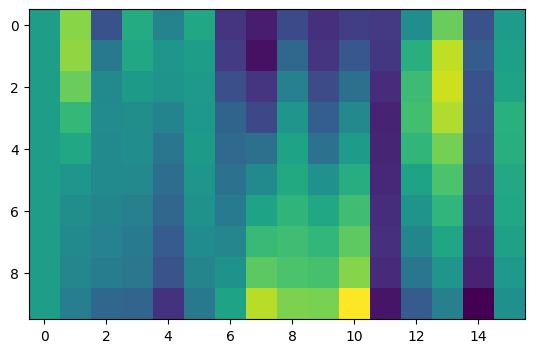

In [62]:
plt.figure()
plt.imshow((dims / dims[0][None,:]).T)

single neurons analysis

In [62]:
import xxhash

def get_unique_decoders(decoders):
    hashes_unique, idx, inv = np.unique([xxhash.xxh3_64_hexdigest(d) for d in decoders], return_index=True, return_inverse=True)
    idx_argsort = np.argsort(idx)
    decoders_unique_sorted = np.array(decoders)[idx][idx_argsort]
    return decoders_unique_sorted, idx, idx_argsort[inv]

In [63]:
decoders, idx, inv = get_unique_decoders([expParams_objs[d]['baselineStuff']['ROIs']['cellWeightings'] for d in dates_toUse])
decoder_dates = {date: i for i,date in zip(inv, dates_toUse)}

In [64]:
decoders[0].shape

(231,)

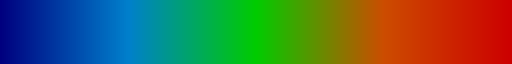

In [65]:
cmap = bnpm.plotting_helpers.simple_cmap([[0,0,0.5], [0,0.5,0.8], [0,0.8,0], [0.8,0.3,0], [0.8,0,0]])
display(cmap)
colors = cmap(np.linspace(0,0.999, len(dates_toUse)))

In [69]:
# win_bounds = [-30*4, 30*4]
idx_decoder_toUse = 0

idx = np.where([v==idx_decoder_toUse for v in decoder_dates.values()])[0]

preThresh_bounds = [110, 120]

et_traces_all, et_fanos, et_means, et_vars, et_dmeans, et_dvars = [], [], [], [], [], []
# plt.figure()
for ii,date in enumerate(dates_toUse):
    et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
        arr=sp_matched[date][np.argsort(decoders[idx_decoder_toUse])[::-1]],
#         arr=np.nan_to_num(loggerVals_rollZ[date][np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num(F_matched[date][np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num((F_matched[date] - Fneu_matched[date]*0.7)[np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num(lva[date].T[np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num(loggerValsAligned_objs[date].T[np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num(loggerVals_rollZ[date][np.argsort(decoders[idx_decoder_toUse])[::-1]]),
#         arr=np.nan_to_num(lva_rollZ[date].T[np.argsort(decoders[idx_decoder_toUse])[::-1]]),
        trigger_signal=trials_111_success[date]['frames'],
        win_bounds=win_bounds,
        trigger_signal_is_idx=True
    )
    
    et_traces_all.append(et_traces)

    et_mean = np.nanmean(np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1)
    et_var  = np.nanvar( np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1)
    
    et_dmean = np.nanmean(np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1) - np.nanmean(np.nanmean(et_traces[:,:,:50], axis=2), axis=1)
    et_dvar  = np.nanvar( np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1) - np.nanvar( np.nanmean(et_traces[:,:,:50], axis=2), axis=1)

    et_fano = np.abs(et_var / et_mean)
    
    et_fanos.append(et_fano)
    et_means.append(et_mean)
    et_vars.append(et_var)
    et_dmeans.append(et_dmean)
    et_dvars.append(et_dvar)

et_fanos = np.stack(et_fanos, axis=0)
et_means = np.stack(et_means, axis=0)
et_vars = np.stack(et_vars, axis=0)
et_dmeans = np.stack(et_dmeans, axis=0)
et_dvars = np.stack(et_dvars, axis=0)

/tmp/ipykernel_5358/2645671987.py:27: RuntimeWarning: Mean of empty slice
  et_mean = np.nanmean(np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1)
/tmp/ipykernel_5358/2645671987.py:28: RuntimeWarning: Mean of empty slice
  et_var  = np.nanvar( np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1)
/tmp/ipykernel_5358/2645671987.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.
  et_var  = np.nanvar( np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1)
/tmp/ipykernel_5358/2645671987.py:30: RuntimeWarning: Mean of empty slice
  et_dmean = np.nanmean(np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1) - np.nanmean(np.nanmean(et_traces[:,:,:50], axis=2), axis=1)
/tmp/ipykernel_5358/2645671987.py:31: RuntimeWarning: Mean of empty slice
  et_dvar  = np.nanvar( np.nanmean(et_traces[:,:,preThresh_bounds[0]:preThresh_bounds[1]], axis=2), axis=1) - np.nanvar( np.n

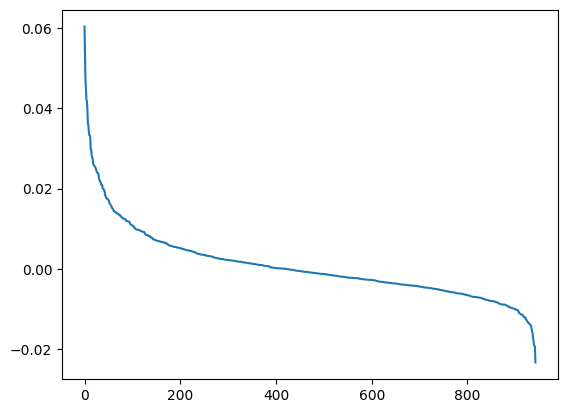

In [70]:
plt.figure()
plt.plot(decoders[idx_decoder_toUse][np.argsort(decoders[idx_decoder_toUse])[::-1]])

<IPython.core.display.Javascript object>


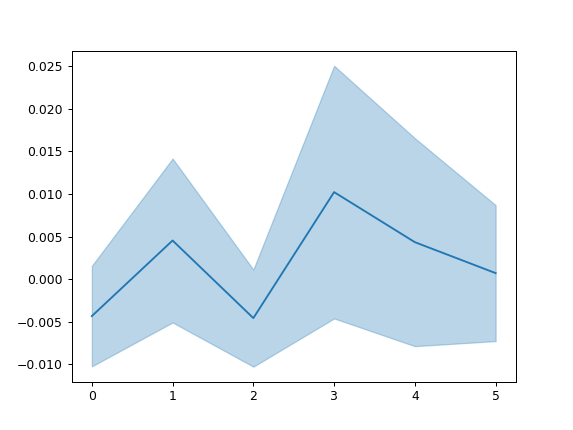

<AxesSubplot:>

In [71]:
val = et_dmeans.copy()

%matplotlib notebook
plt.figure()
bnpm.plotting_helpers.shaded_error_bar(val[idx,:30])
# bnpm.plotting_helpers.shaded_error_bar(val[idx,:100])
# bnpm.plotting_helpers.shaded_error_bar(val[idx,100:-100])
# bnpm.plotting_helpers.shaded_error_bar(val[idx,-5:])
# plt.ylim([0,1])

In [72]:
import bnpm.similarity

In [73]:
# lva = {date: bnpm.similarity.pairwise_orthogonalization(np.nan_to_num(np.array(loggerValsAligned_objs[date], dtype=np.float32)), np.nan_to_num(F_matched[date].T))[0] for date in dates_toUse}

In [ ]:
# wlen = Fs * 60 * 15

# lva_rollZ = {date: zscore_rolling(l, wlen=wlen, X_denom=loggerValsAligned_objs[date]) for date,l in tqdm(lva.items())}

<IPython.core.display.Javascript object>


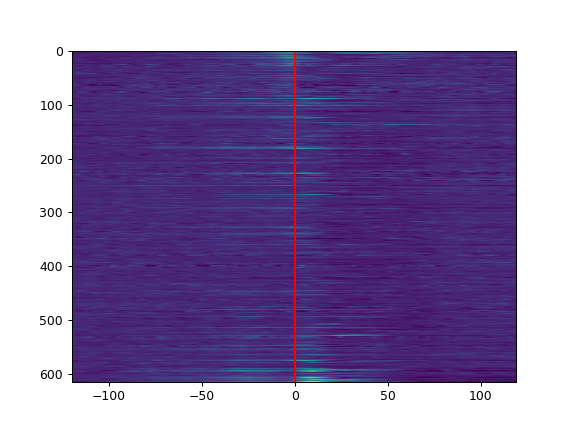

<IPython.core.display.Javascript object>


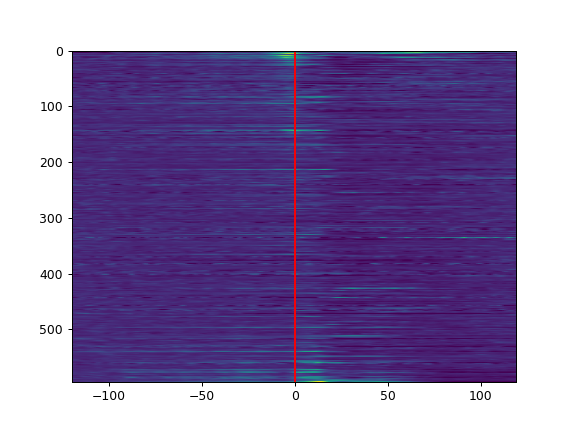

<IPython.core.display.Javascript object>


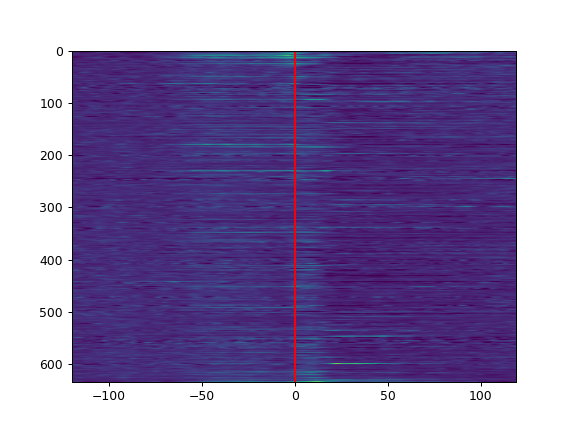

<IPython.core.display.Javascript object>


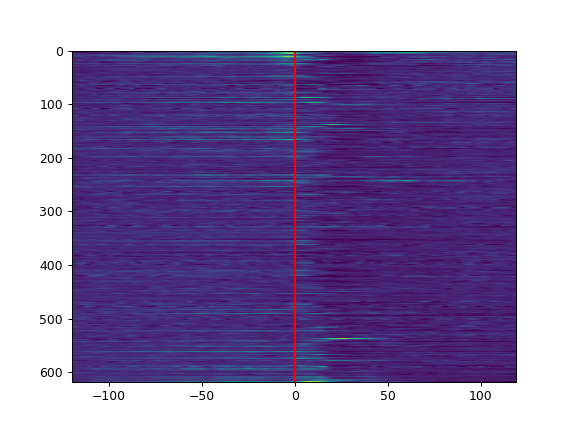

<IPython.core.display.Javascript object>


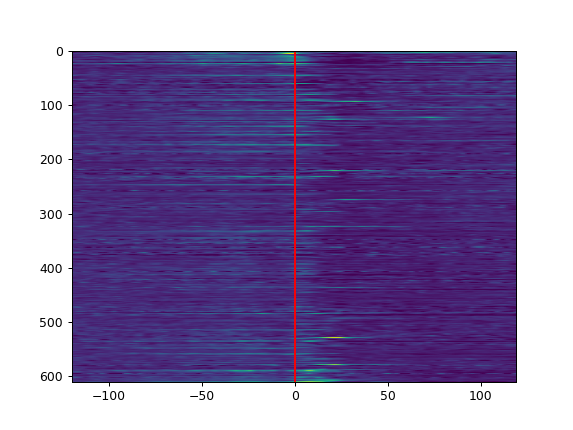

<IPython.core.display.Javascript object>


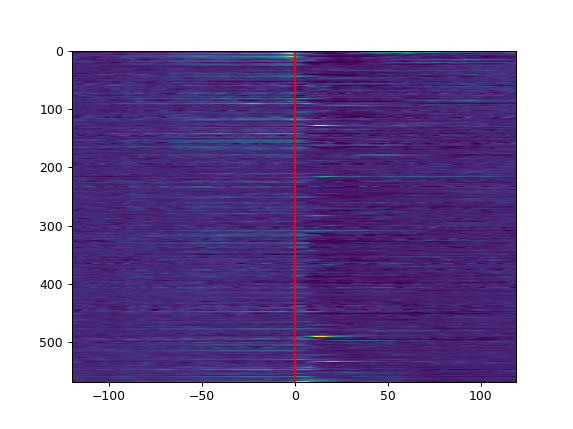

<IPython.core.display.Javascript object>


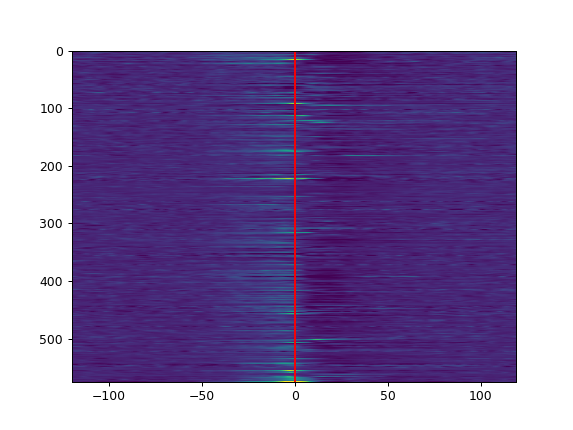

<IPython.core.display.Javascript object>


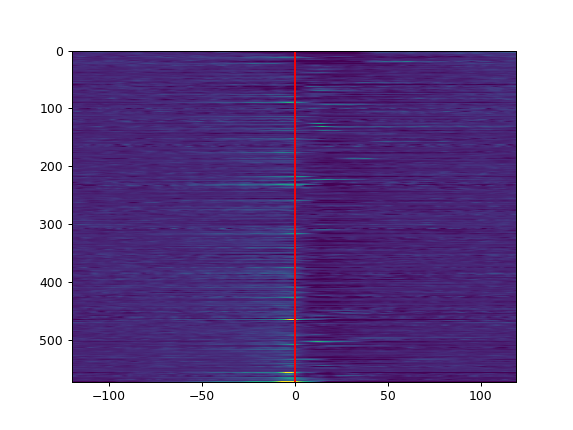

<IPython.core.display.Javascript object>


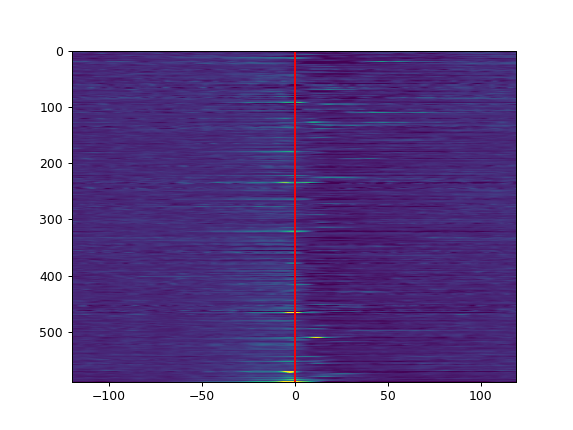

<IPython.core.display.Javascript object>


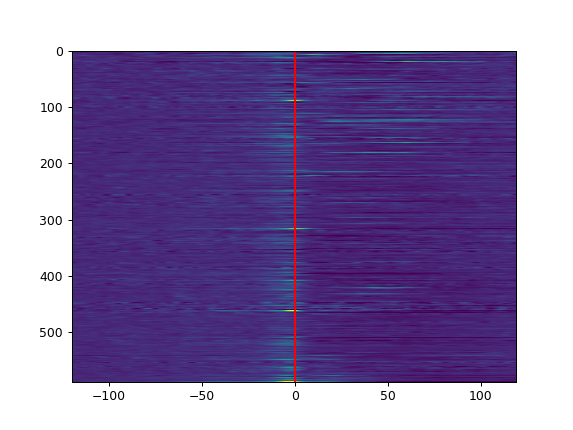

<IPython.core.display.Javascript object>


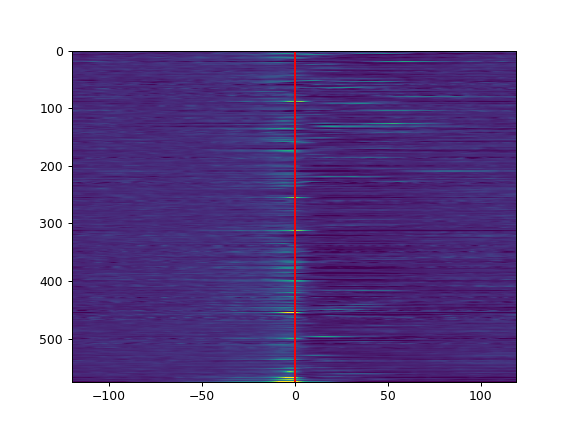

<IPython.core.display.Javascript object>


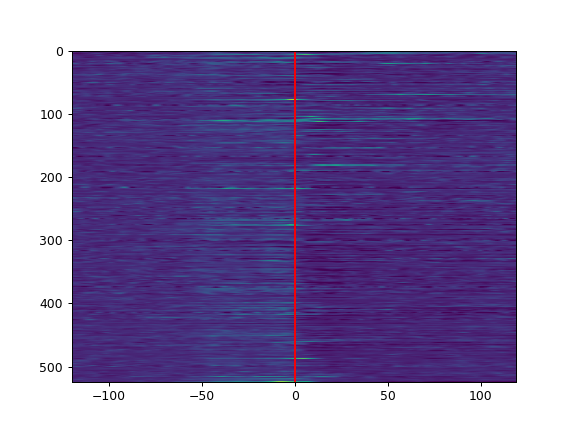

<IPython.core.display.Javascript object>


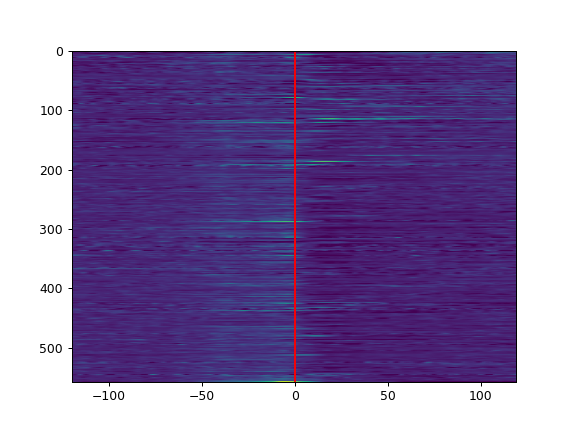

<IPython.core.display.Javascript object>


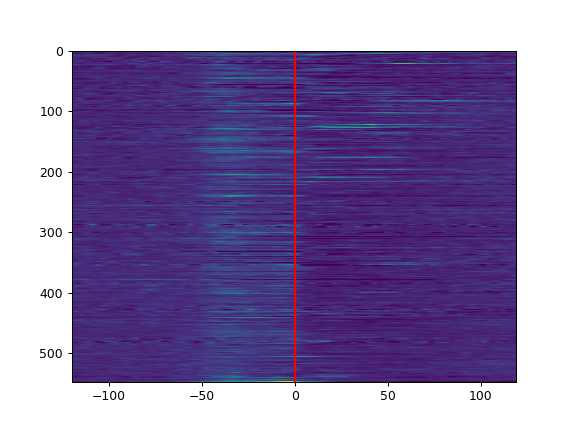

<IPython.core.display.Javascript object>


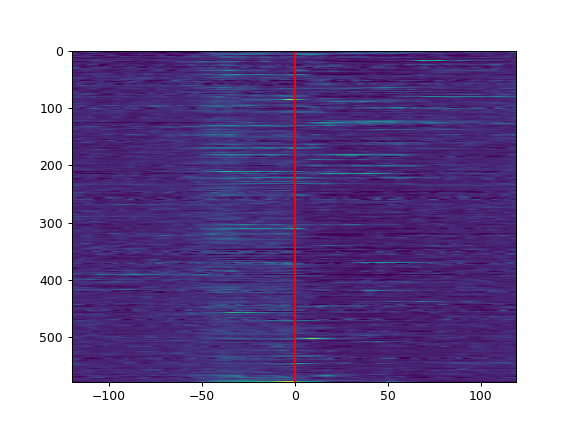

<IPython.core.display.Javascript object>


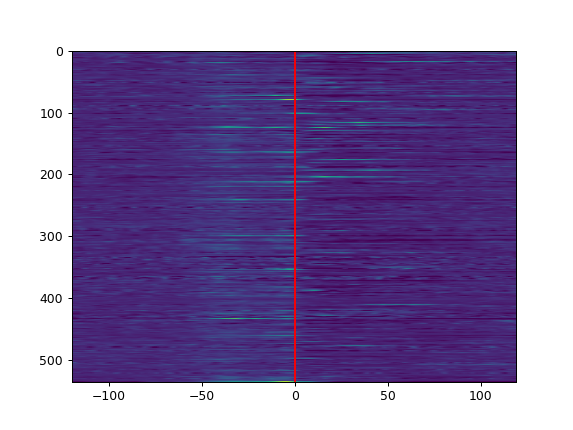

In [75]:
for date in dates_toUse:
    arr = sp_matched[date] - np.mean(sp_matched[date], axis=1, keepdims=True)
    arr = arr[np.argsort(decoders[idx_decoder_toUse])[::-1]]
    # date = '20221021'
    et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
#         arr=sp_matched[date].T @ expParams_objs[date]['baselineStuff']['ROIs']['cellWeightings'],
#         arr=sp_raw[date] - np.mean(sp_raw[date], axis=1, keepdims=True),
        arr=arr,
    #     arr=loggerAligned_dfs[date]['decoder']['cursor_brain_raw'].to_numpy(),
    #     arr=sp_matched[date].mean(0),
        trigger_signal=trials_111_success[date]['frames'],
    #     trigger_signal=t[:],
        win_bounds=[-30*4, 30*4],
        trigger_signal_is_idx=True,
#         show_plot=True
    )

    out_mean = et_traces.mean(1)
    out_mean = out_mean[np.logical_not(np.isnan(out_mean.mean(1)))]
    
    plt.figure()
#     plt.imshow(np.nan_to_num(et_traces).mean(1), clim=[-0.02,0.06], aspect='auto', extent=(xAxis[0], xAxis[-1], mean_traces_sorted.shape[0], 0))
    plt.imshow(out_mean, clim=[-0.02,0.15], aspect='auto', extent=(xAxis[0], xAxis[-1], out_mean.shape[0], 0))
    plt.plot([0,0], [0, out_mean.shape[0]], 'r')
#     break

<IPython.core.display.Javascript object>


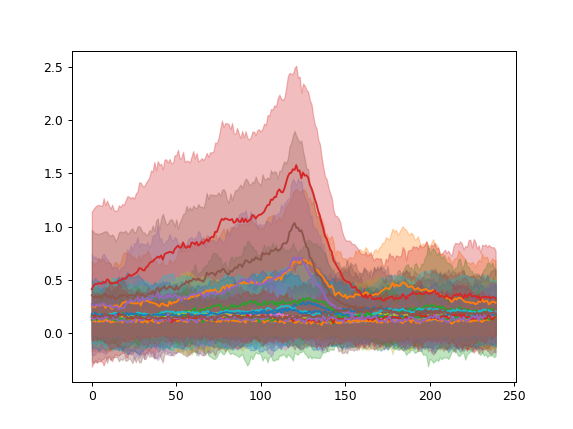

In [78]:
plt.figure()
for date in dates_toUse:
    arr = dFoF_matched[date][np.argsort(decoders[idx_decoder_toUse])[::-1]][10]
#     arr = sp_matched[date][30]
    # date = '20221021'
    et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
#         arr=sp_matched[date].T @ expParams_objs[date]['baselineStuff']['ROIs']['cellWeightings'],
#         arr=sp_raw[date] - np.mean(sp_raw[date], axis=1, keepdims=True),
        arr=arr,
    #     arr=loggerAligned_dfs[date]['decoder']['cursor_brain_raw'].to_numpy(),
    #     arr=sp_matched[date].mean(0),
        trigger_signal=trials_111_success[date]['frames'],
    #     trigger_signal=t[:],
        win_bounds=[-30*4, 30*4],
        trigger_signal_is_idx=True,
#         show_plot=True
    )

#     out_mean = et_traces.mean(1)
#     out_mean = out_mean[np.logical_not(np.isnan(out_mean.mean(1)))]
    
#     plt.figure()
# #     plt.imshow(np.nan_to_num(et_traces).mean(1), clim=[-0.02,0.06], aspect='auto', extent=(xAxis[0], xAxis[-1], mean_traces_sorted.shape[0], 0))
#     plt.imshow(out_mean, clim=[-0.02,0.15], aspect='auto', extent=(xAxis[0], xAxis[-1], out_mean.shape[0], 0))
#     plt.plot([0,0], [0, out_mean.shape[0]], 'r')
# #     break
    bnpm.plotting_helpers.shaded_error_bar(et_traces.T)

In [66]:
idx_decoder_toUse = 0

In [86]:
et_traces.shape

(2276, 222, 240)

In [87]:
out_mean.shape

(231, 222)

/tmp/ipykernel_61459/3026352766.py:26: RuntimeWarning: Mean of empty slice
  out_mean = np.nanmean(et_traces[:,:,115:120], axis=2) - np.nanmean(et_traces[:,:,:50], axis=2)


<IPython.core.display.Javascript object>


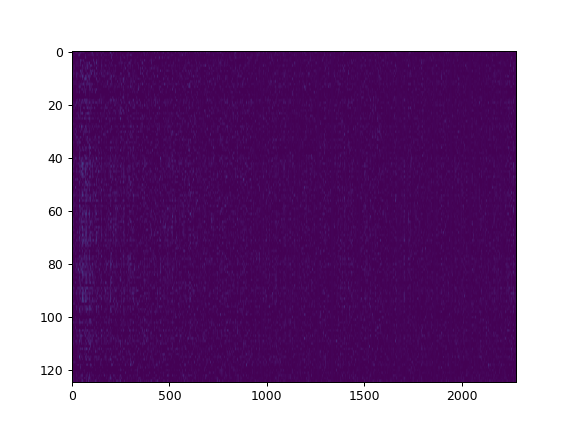

<IPython.core.display.Javascript object>


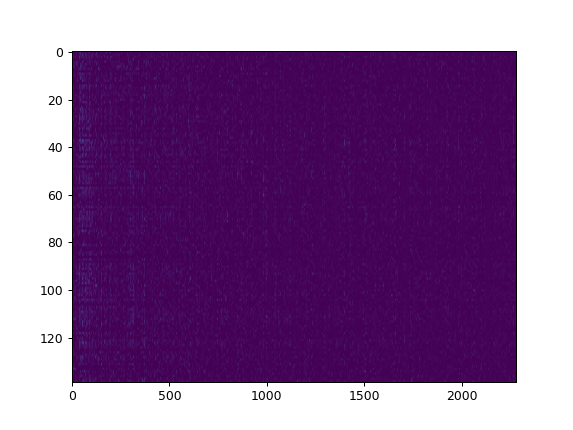

<IPython.core.display.Javascript object>


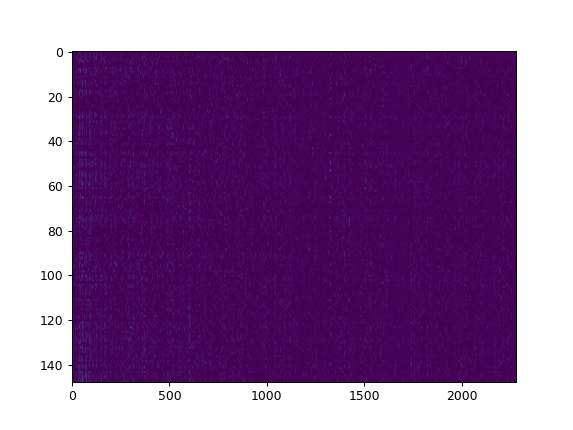

<IPython.core.display.Javascript object>


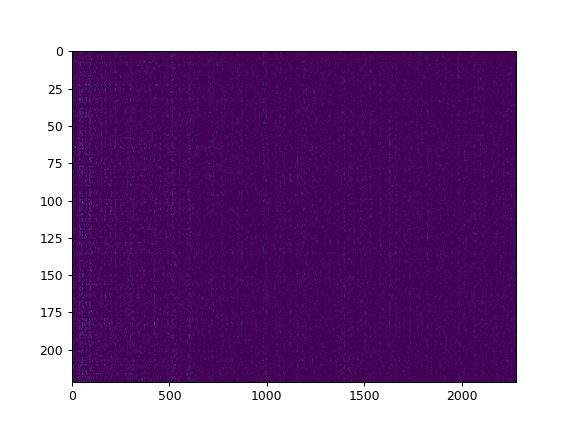

In [88]:
%matplotlib notebook
actVecs = {}
# for date in dates_toUse:
for date in dates_toUse[1:]:
#     arr = loggerVals_rollZ[date]
    arr = sp_matched[date]
#     arr = F_matched[date]
#     arr = dFoF_matched[date]
#     arr = arr[np.argsort(decoders[idx_decoder_toUse])[::-1]]
    # date = '20221021'
    et_traces, xAxis, windows = bnpm.timeSeries.event_triggered_traces(
#         arr=sp_matched[date].T @ expParams_objs[date]['baselineStuff']['ROIs']['cellWeightings'],
#         arr=sp_raw[date] - np.mean(sp_raw[date], axis=1, keepdims=True),
        arr=arr,
    #     arr=loggerAligned_dfs[date]['decoder']['cursor_brain_raw'].to_numpy(),
    #     arr=sp_matched[date].mean(0),
        trigger_signal=trials_111_success[date]['frames'],
    #     trigger_signal=t[:],
        win_bounds=[-30*4, 30*4],
        trigger_signal_is_idx=True,
#         show_plot=True
    )
    et_traces[np.abs(et_traces) > 5] = np.nan

#     out_mean = np.nanmean(et_traces, axis=1)
    out_mean = np.nanmean(et_traces[:,:,115:120], axis=2) - np.nanmean(et_traces[:,:,:50], axis=2)
#     out_mean = out_mean[np.logical_not(np.isnan(out_mean.mean(1)))]
    out_mean = np.nan_to_num(out_mean)
    
#     out_mean = out_mean[np.argsort(decoders[idx_decoder_toUse])[::-1]]
    
    actVecs.update({date: out_mean})
    
    plt.figure()
#     plt.imshow(np.nan_to_num(et_traces).mean(1), clim=[-0.02,0.06], aspect='auto', extent=(xAxis[0], xAxis[-1], mean_traces_sorted.shape[0], 0))
    plt.imshow(
        out_mean.T, 
        clim=[-0.02,2.15],
        aspect='auto', 
#         extent=(xAxis[0], xAxis[-1], out_mean.shape[0], 0)
    )
#     plt.plot([0,0], [0, out_mean.shape[0]], 'r')
#     break

In [89]:
actVecs_cat = np.concatenate([v for v in actVecs.values()], axis=1) 

actVecs_cc = np.corrcoef(actVecs_cat.T)

In [153]:
trial_num_cumsum = np.concatenate(([0], np.cumsum([l.shape[1] for l in actVecs.values()])[:]))

In [154]:
actVecs_cc_rolling = np.stack([np.pad(np.diag(actVecs_cc, k=ii), pad_width=(ii,0), mode='constant', constant_values=np.nan) for ii in range(1,100)], axis=1)

<IPython.core.display.Javascript object>


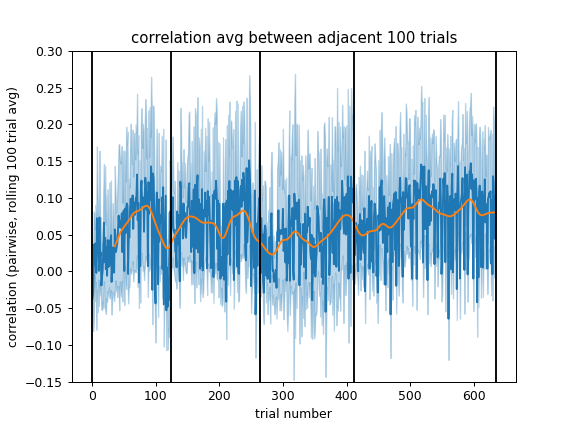

/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/bnpm/plotting_helpers.py:184: RuntimeWarning: Mean of empty slice
  y_center = reduction_center(data, axis=1)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_61459/2297011568.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(bnpm.timeSeries.simple_smooth(np.nanmean(actVecs_cc_rolling, axis=1), sig=10))


(-0.15, 0.3)

In [183]:
plt.figure()
bnpm.plotting_helpers.shaded_error_bar(actVecs_cc_rolling)
plt.plot(bnpm.timeSeries.simple_smooth(np.nanmean(actVecs_cc_rolling, axis=1), sig=10))

[plt.plot([n,n], [-0.15, 0.3], 'k') for n in trial_num_cumsum]

plt.xlabel('trial number')
plt.ylabel('correlation (pairwise, rolling 100 trial avg)')
plt.title('correlation avg between adjacent 100 trials')
plt.ylim([-0.15, 0.3])

In [180]:
actVecs_cc_seshMean = np.array([np.triu(actVecs_cc[idx1:idx2]).mean() for idx1,idx2 in zip(trial_num_cumsum[:-1], trial_num_cumsum[1:])])
actVecs_cc_seshStd = np.array([np.triu(actVecs_cc[idx1:idx2]).std() for idx1,idx2 in zip(trial_num_cumsum[:-1], trial_num_cumsum[1:])])
actVecs_cc_seshSem = actVecs_cc_seshStd / np.sqrt(trial_num_cumsum[1:])

<IPython.core.display.Javascript object>


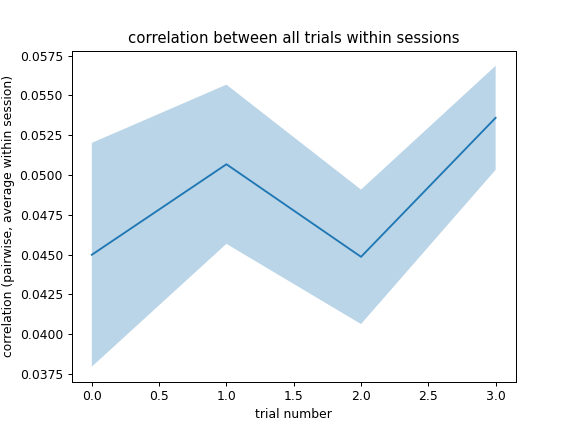

Text(0.5, 1.0, 'correlation between all trials within sessions')

In [184]:
plt.figure()
plt.plot(np.arange(len(actVecs_cc_seshMean)), actVecs_cc_seshMean)
plt.fill_between(np.arange(len(actVecs_cc_seshMean)), actVecs_cc_seshMean - actVecs_cc_seshSem, actVecs_cc_seshMean + actVecs_cc_seshSem, alpha=0.3)

plt.xlabel('trial number')
plt.ylabel('correlation (pairwise, average within session)')
plt.title('correlation between all trials within sessions')

<IPython.core.display.Javascript object>


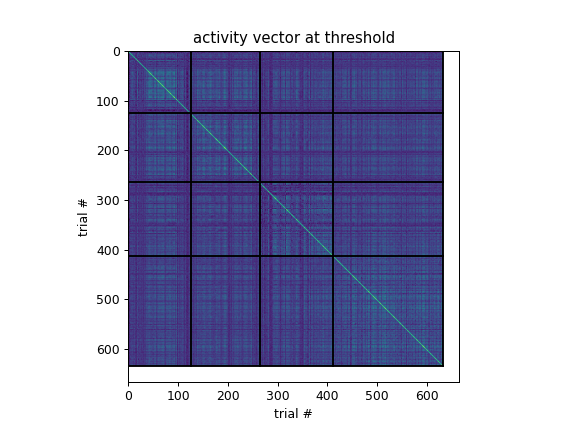

In [157]:
plt.figure()
plt.imshow(actVecs_cc, clim=[-0.1, 0.7])
plt.xlabel('trial #')
plt.ylabel('trial #')
plt.title('activity vector at threshold')
[plt.plot([n,n],[0,trial_num_cumsum[-1]], 'k') for n in trial_num_cumsum]
[plt.plot([0,trial_num_cumsum[-1]], [n,n], 'k') for n in trial_num_cumsum];

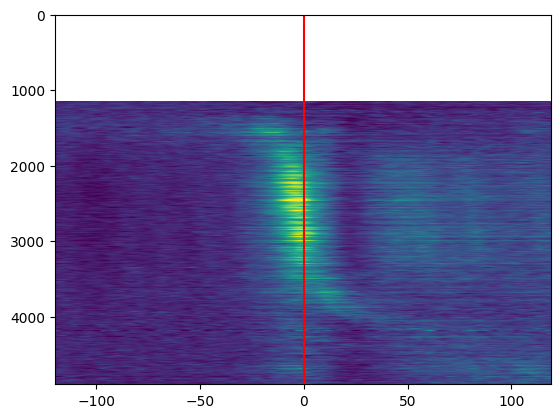

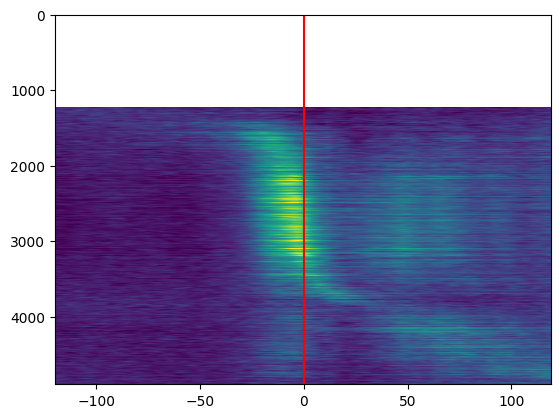

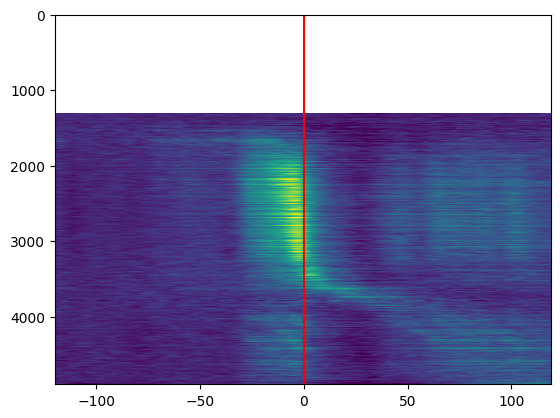

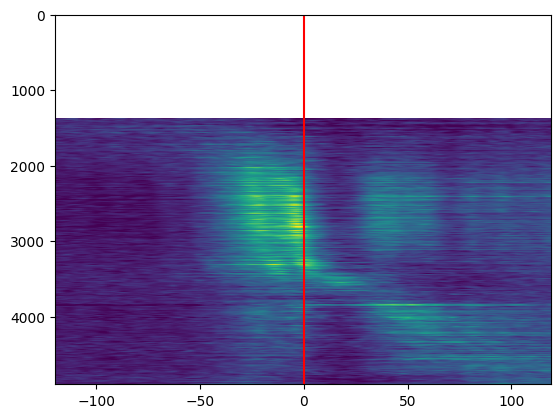

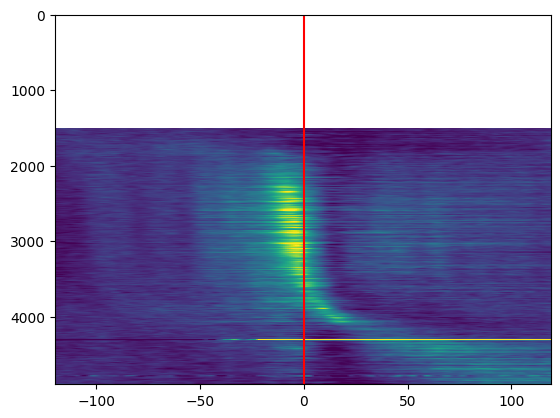

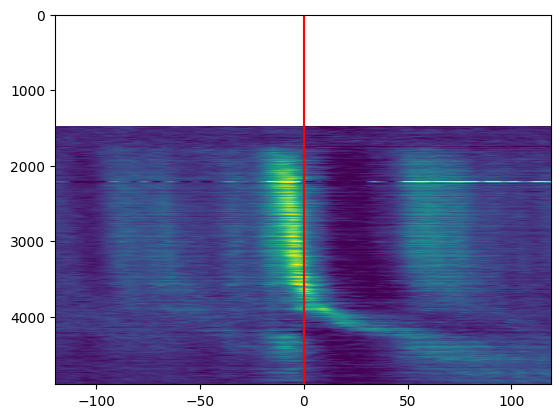

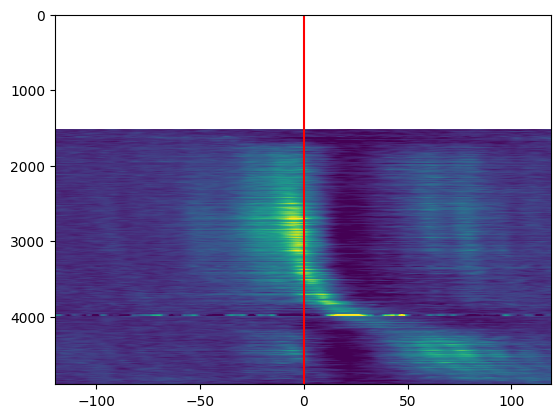

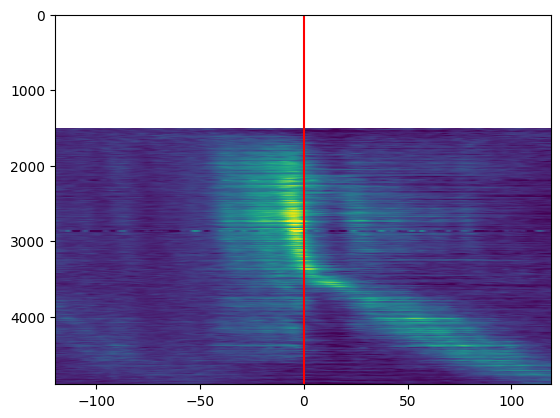

In [150]:
# for date in dates_toUse:
for date in dates_toUse[1:]:
    arr = sp_matched[date] - np.mean(sp_matched[date], axis=1, keepdims=True)
    # date = '20221021'
    mean_traces_sorted, cv_idx, et_traces, xAxis, windows = bnpm.timeSeries.make_sorted_event_triggered_average(
#         arr=sp_matched[date].T @ expParams_objs[date]['baselineStuff']['ROIs']['cellWeightings'],
#         arr=sp_raw[date] - np.mean(sp_raw[date], axis=1, keepdims=True),
        arr=arr,
    #     arr=loggerAligned_dfs[date]['decoder']['cursor_brain_raw'].to_numpy(),
    #     arr=sp_matched[date].mean(0),
        trigger_signal=trials_111_success[date]['frames'],
    #     trigger_signal=t[:],
        win_bounds=[-30*4, 30*4],
        trigger_signal_is_idx=True,
#         show_plot=True
    )

    plt.figure()
    plt.imshow(mean_traces_sorted, clim=[-0.02,0.14], aspect='auto', extent=(xAxis[0], xAxis[-1], mean_traces_sorted.shape[0], 0))
    plt.plot([0,0], [0, mean_traces_sorted.shape[0]], 'r')
#     break

visualize the cells over days

In [94]:
import bnpm.plotting_helpers

In [95]:
import roicat

In [96]:
fovs = roicat.tracking.visualization.compute_colored_FOV(
    spatialFootprints=roicat_out['ROIs']['ROIs_aligned'],
    FOV_height=roicat_out['ROIs']['frame_height'],
    FOV_width=roicat_out['ROIs']['frame_width'],
    labels=roicat_out['UCIDs_bySession'],
)

In [97]:
fovs = roicat.tracking.visualization.compute_colored_FOV(
    spatialFootprints=rois_matched,
    FOV_height=roicat_out['ROIs']['frame_height'],
    FOV_width=roicat_out['ROIs']['frame_width'],
    labels=[np.arange(rois_matched[0].shape[0]) for _ in range(len(rois_matched))],
)

<IPython.core.display.Javascript object>


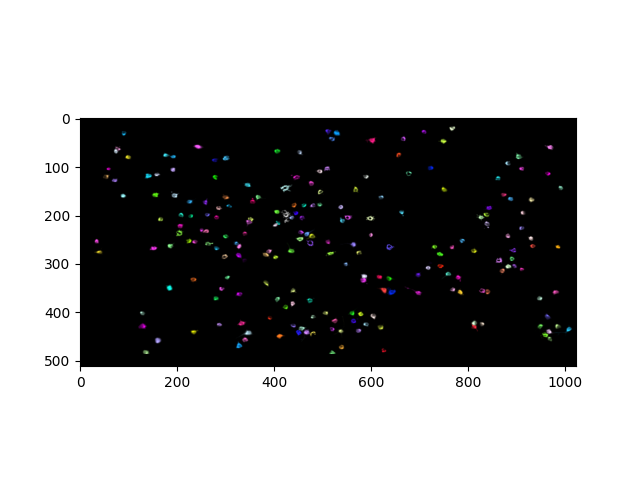

interactive(children=(IntSlider(value=0, description='i_frame', max=6), Output()), _dom_classes=('widget-inter…

In [98]:
%matplotlib notebook

roicat.tracking.visualization.display_toggle_image_stack(fovs)

### Save results

Make a nice little dictionary with all the relevant information

In [33]:
name_animal = 'mouse_2_6'

In [63]:
data_output = {
    'name_animal': name_animal,
    'paths_logger': paths_logger,
    'paths_expParams': paths_expParams,
    'dirs_logger': dirs_logger,
    'paths_transfer': paths_transfer,
#     'logger_objs': logger_objs,
#     'expParams_objs': expParams_objs,
#     'logger_dfs': logger_dfs,
    'n_sessions': n_sessions,
    'trials_duration_nowTime': trials_duration_nowTime,
    'trials_success': trials_success,
    'trials_type_111': trials_type_111,
    'trials_numSuccess__111': trials_numSuccess__111,
    'trials_duration_time__success_111': trials_duration_time__success_111,
    'edges': edges,
    'trials_durationHist_time__success_111': trials_durationHist_time__success_111,
    'names_states': names_states,
}

save the analysis outputs and the logger and expParams objects

In [68]:
bnpm.file_helpers.pickle_save(
    obj=data_output,
    path_save=str(Path(r'/media/rich/bigSSD/analysis_data/BMI/analysis_BMI_rewards').resolve() / name_animal / (name_animal + '__analysis_BMI_rewards' + '.pkl')),
    mkdir=True,
)

bnpm.file_helpers.pickle_save(
    obj={
        'logger_dfs': logger_dfs,
        'logger_objs': logger_objs,
        'expParams_objs': expParams_objs,
    },
    path_save=str(Path(r'/media/rich/bigSSD/analysis_data/BMI/analysis_BMI_rewards').resolve() / name_animal / (name_animal + '__logger_expParams' + '.pkl')),
    mkdir=True
)